# Gradient Descent Step Regimes

Gabriel Konar-Steenberg, 2022-10-24

## Problem Statement

We are asked to investigate the behavior of
$$f(x) = \|A \vec x - \vec b\|_2$$
under gradient descent
$$\vec x_0=(0, 0)\quad \vec x_{i+1} = \vec x_i-t_i \nabla f(\vec x_i)$$
with the following step regimes:
1. Constant step: $t_i = 1$
2. Exponentially decreasing step: $t_i = (5/6)^i$
3. Harmonically decreasing step: $t_i = \frac{1}{i+1}$

Will any of the step regimes work for all choices of $A$ and $\vec b$?

## Solution

We start, as usual, by defining parameters and creating some graphing apparatus. We will let

 * $A_0 = I_2$,
 * $A_1 = \begin{bmatrix} 10 & 0 \\ 0 & 1 \end{bmatrix}$, and
 * $A_2 = \begin{bmatrix} 15 & 8 \\ 6 & 5 \end{bmatrix}$.

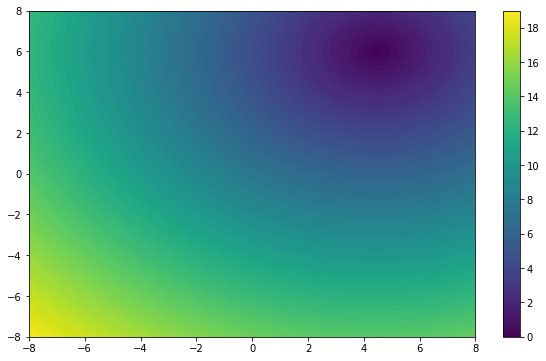

In [1]:
import numpy as np
import matplotlib.pyplot as plt

norm2 = np.linalg.norm  # Alias for the Euclidean norm

# Parameters of the problem
n = 2  # dimensionality

# Various choices for A
A0 = np.eye(2)
A1 = np.array([[10, 0], [0, 1]])
A2 = np.array([[15, 8], [6, 5]])
A = A0

# Various choices for b
b0 = np.array([[4.5], [6]])
b = b0

# Various choices for step
step0 = lambda i: 1
step1 = lambda i: (5/6)**i
step2 = lambda i: 1/(i+1)
step = step0

x0 = np.zeros((2, 1))

def f(x):
    assert x.shape[0] == 2
    assert len(x.shape) == 2
    return norm2(A@x-b)

def f_1d(x):
    return f(x.reshape((2, -1)))

def plot_problem(fig = None, ax = None, xbounds = (-8, 8), ybounds = (-8, 8), do_colorbar=True):
    if fig is None or ax is None: fig, ax = plt.subplots(figsize=(10,6))
    xfield = np.linspace(*xbounds, 200)
    yfield = np.linspace(*ybounds, 200)
    xcoords, ycoords = np.meshgrid(xfield, yfield)
    zcoords = np.apply_along_axis(f_1d, 0, [xcoords, ycoords])
    colors = ax.contourf(xcoords, ycoords, zcoords, 80)
    if do_colorbar: fig.colorbar(colors)
    ax.set_xlim(*xbounds)
    ax.set_ylim(*ybounds)
    return fig, ax

plot_problem()
plt.show()

Now, let's define a generic gradient descent routine that we can use to investigate all these questions.

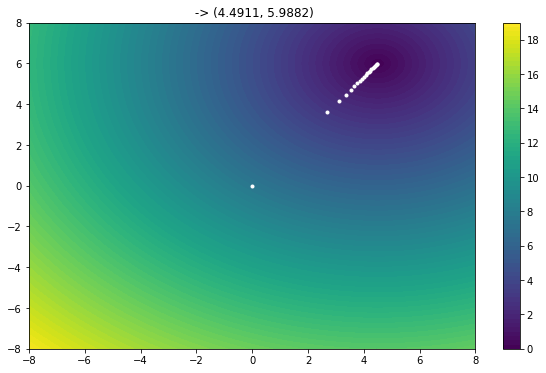

In [2]:
def grad_1d(pt, delta = 1e-4):  # Returns an approximation of the gradient of f at a given point
    xs = np.tile(pt, (*pt.shape, 1))  # Make n copies of x so we can perturb it in n dimensions
    xh = xs + np.eye(*xs.shape)*delta  # Perturb along each dimension
    initial = np.apply_along_axis(f_1d, -1, xs)
    final = np.apply_along_axis(f_1d, -1, xh)
    return (final-initial)/delta  # Calculate the slope and reshape to taste  

def grad_col(pt, *args):  # grad_1d but accepts and returns column vectors
    return grad_1d(pt.T[0], *args).reshape(pt.shape)

def run_gradient_descent(n_iters, my_A=A, my_b=b, my_step=step):
    global A, b, step  # Forgive me my globals
    A = my_A
    b = my_b
    step = my_step

    x = x0
    pts = [x]
    i = 0
    while i < n_iters:
        x = x-step(i)*grad_col(x)
        pts.append(x)
        i += 1
    return pts

def viz_gradient_descent(n_iters, n_pts, fig=None, ax=None, my_A=A, my_b=b, my_step=step, title="", do_colorbar=True):
    pts = run_gradient_descent(n_iters, my_A, my_b, my_step)[::max(1, n_iters//n_pts)]
    fig, ax = plot_problem(fig=fig, ax=ax, do_colorbar=do_colorbar)
    ax.plot(*(np.array(pts)[:,:,0]).T, "w.")
    ax.set_title(title+f" -> ({pts[-1][0,0]:.4f}, {pts[-1][1,0]:.4f})")

viz_gradient_descent(1000, 20, my_step=step2)
plt.show()

Above, we have shown 20 evenly sampled points from a 1000-iteration gradient descent using the harmonic step. Now, let's see what happens for all three values of $A$ and all three step regimes.

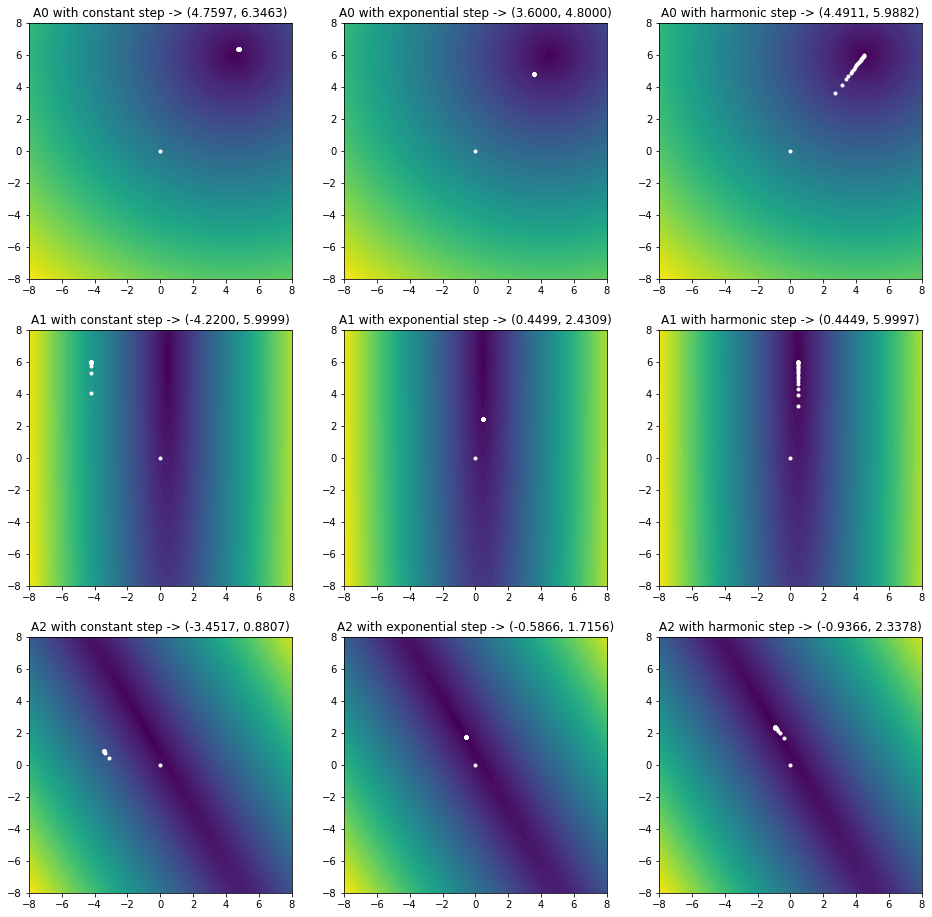

In [3]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    this_A = [A0, A1, A2][i]
    this_A_label = ["A0", "A1", "A2"][i]
    for j in range(3):
        this_step = [step0, step1, step2][j]
        this_step_label = ["constant", "exponential", "harmonic"][j]

        viz_gradient_descent(1000, 20, fig=fig, ax=axs[i][j], my_A=this_A, my_step=this_step, title=f"{this_A_label} with {this_step_label} step", do_colorbar=False)

It looks like the constant step does not correctly converge for any of these choices of $A$, whereas the harmonic step plausibly might for all three. We conjecture based on these examples that the harmonic step elicits correct convergence for all $A$.